<a href="https://colab.research.google.com/github/yiftachsa/Machine-Learning/blob/main/2025_Ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3 Names and IDs
 1. Tomer Lev-Lehman 203458674
 2. Yiftach Savransky 312141369

In [ ]:
!pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.0 MB/s eta 0:00:00


In [ ]:
#dependencies
from sklearn.model_selection import train_test_split
# mount google drive

import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from  sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score

from keras.metrics import AUC
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score, classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


from collections import Counter
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# **Load data**



In [ ]:
# path to csv dataset in mounted drive
orig_url='https://drive.google.com/file/d/1_w4YVAAxHfJ0h_-4z0w4Mk5JkhbjFn2c/view?usp=sharing'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
data_frame = pd.read_csv(csv_raw)


# **Preprocess**

We preprocess the data in two main stages: encoding and normalizing



**1.   Encoding**

Every binary feature we convert to $\{0,1\}$.

Every Multi-value categorical feature we encode using one hot encoder and dummy variables.

**2.   Normalization**

Every numeric feature is normalized using min-max normaliztion to the range: $[0,1]$

Those steps were taken to ensure that the feature are all within the same range.

**Missing values** were also addressed in the code below.


In [ ]:
misssing_count = data_frame.apply(lambda x: sum(x.isnull()),axis=0)
misssing_count = misssing_count[misssing_count>0]
misssing_count

,0
NEWSITEID,465


In [ ]:
df_info = pd.DataFrame({
    "unique_values": data_frame.nunique(),
    "dtype": data_frame.dtypes,
    "missing_count": data_frame.apply(lambda x: sum(x.isnull()),axis=0)
})

bool_cols = df_info[df_info["unique_values"]==2].index.tolist()
cat_cols = df_info[(df_info["unique_values"]>2) & (df_info["unique_values"]<10)].index.tolist() + ["NEWSITEID"]
num_cols = df_info.loc[~df_info.index.isin(bool_cols + cat_cols)].index.tolist()


In [ ]:
print(bool_cols)

['INTENSIVE', 'INCLUSIONFRS', 'NOAGENTS', 'ASPIRIN', 'SUB_CKD', 'RACE_BLACK', 'FEMALE', 'SUB_CVD', 'SUB_CLINICALCVD', 'SUB_SUBCLINICALCVD', 'SUB_SENIOR', 'STATIN', 'EVENT_PRIMARY']


In [ ]:
processed_df = pd.DataFrame()
#label encoding
# Converting Binary Categorical Variables
le = LabelEncoder()
for bool_col in bool_cols:
    processed_df[bool_col] = le.fit_transform(data_frame[bool_col])

# Converting Multi-value Categorical Variables
for cat_col in cat_cols:
  processed_df = processed_df.join(pd.get_dummies(data_frame[cat_col], prefix=cat_col))

# Normalizing numeric colums - min-max normalization
for num_col in num_cols:
  min_max_scaler = preprocessing.MinMaxScaler()
  x = data_frame[num_col].values.reshape(-1, 1) #returns a numpy array
  x_scaled = min_max_scaler.fit_transform(x)
  processed_df[num_col] = pd.DataFrame(x_scaled)

processed_df[processed_df.select_dtypes(bool).columns] = processed_df.select_dtypes(bool).astype(int)

processed_df_info = pd.DataFrame({
    "unique_values": processed_df.nunique(),
    "dtype": processed_df.dtypes,
    "missing_count": processed_df.apply(lambda x: sum(x.isnull()),axis=0)
})
processed_df_info

,unique_values,dtype,missing_count
INTENSIVE,2,int64,0
INCLUSIONFRS,2,int64,0
NOAGENTS,2,int64,0
ASPIRIN,2,int64,0
SUB_CKD,2,int64,0
...,...,...,...
GLUR,129,float64,0
HDL,114,float64,0
TRR,432,float64,0
UMALCR,3084,float64,0


In [ ]:
outcome = "EVENT_PRIMARY"
predictors = list(processed_df.columns.values)
predictors.remove(outcome)
print(f"outcome: {outcome}")
print(f"predictors: {predictors}")

outcome: EVENT_PRIMARY
predictors: ['INTENSIVE', 'INCLUSIONFRS', 'NOAGENTS', 'ASPIRIN', 'SUB_CKD', 'RACE_BLACK', 'FEMALE', 'SUB_CVD', 'SUB_CLINICALCVD', 'SUB_SUBCLINICALCVD', 'SUB_SENIOR', 'STATIN', 'N_AGENTS_0', 'N_AGENTS_1', 'N_AGENTS_2', 'N_AGENTS_3', 'N_AGENTS_4', 'N_AGENTS_5', 'N_AGENTS_6', 'SMOKE_3CAT_1', 'SMOKE_3CAT_2', 'SMOKE_3CAT_3', 'RACE4_BLACK', 'RACE4_HISPANIC', 'RACE4_OTHER', 'RACE4_WHITE', 'SBPTERTILE_1', 'SBPTERTILE_2', 'SBPTERTILE_3', 'NEWSITEID_1.0', 'NEWSITEID_2.0', 'NEWSITEID_3.0', 'NEWSITEID_4.0', 'NEWSITEID_5.0', 'NEWSITEID_6.0', 'NEWSITEID_8.0', 'NEWSITEID_9.0', 'NEWSITEID_10.0', 'NEWSITEID_11.0', 'NEWSITEID_12.0', 'NEWSITEID_13.0', 'NEWSITEID_15.0', 'NEWSITEID_18.0', 'NEWSITEID_19.0', 'NEWSITEID_20.0', 'NEWSITEID_21.0', 'NEWSITEID_22.0', 'NEWSITEID_23.0', 'NEWSITEID_24.0', 'NEWSITEID_25.0', 'NEWSITEID_27.0', 'NEWSITEID_29.0', 'NEWSITEID_31.0', 'NEWSITEID_32.0', 'NEWSITEID_33.0', 'NEWSITEID_36.0', 'NEWSITEID_37.0', 'NEWSITEID_38.0', 'NEWSITEID_40.0', 'NEWSITEID_4

In [ ]:
# data_frame.apply(lambda x: sum(x.isnull()),axis=0)
# Missing values - thee only feature which has missing values is NEWSITEID - 465 missing.
# we will regard the missing value - NA as another value.
processed_df = pd.DataFrame()
#label encoding
# Converting Categorical Variables
le_features = ["INTENSIVE","INCLUSIONFRS","NOAGENTS", "ASPIRIN", "SUB_CKD", "RACE_BLACK", "FEMALE", "SUB_CVD","SUB_CLINICALCVD","SUB_SUBCLINICALCVD","SUB_SENIOR","STATIN","EVENT_PRIMARY"]
le = LabelEncoder()
for i in le_features:
    processed_df[i] = le.fit_transform(data_frame[i])

#dummy variable - One Hot Encoder
dummy_features = ["NEWSITEID", "RACE4"]

for i in dummy_features:
  processed_df = processed_df.join(pd.get_dummies(data_frame[i], prefix=i))

#normalize
norm_features = ["RISK10YRS", "N_AGENTS","SBP", "DBP", "EGFR", "SMOKE_3CAT", "SCREAT", "AGE","CHR","GLUR","HDL","TRR","UMALCR","BMI","SBPTERTILE"]

for i in norm_features:
  min_max_scaler = preprocessing.MinMaxScaler()
  x = data_frame[i].values.reshape(-1, 1) #returns a numpy array
  x_scaled = min_max_scaler.fit_transform(x)
  processed_df[i] = pd.DataFrame(x_scaled)

display(processed_df)
outcome = "EVENT_PRIMARY"
predictors = list(processed_df.columns.values)
predictors.remove("EVENT_PRIMARY")
print(f"outcome: {outcome}")
print(f"predictors: {predictors}")



,INTENSIVE,INCLUSIONFRS,NOAGENTS,ASPIRIN,SUB_CKD,RACE_BLACK,FEMALE,SUB_CVD,SUB_CLINICALCVD,SUB_SUBCLINICALCVD,...,SMOKE_3CAT,SCREAT,AGE,CHR,GLUR,HDL,TRR,UMALCR,BMI,SBPTERTILE
0,1,1,0,1,0,0,0,1,1,0,...,1.0,0.190608,0.250,0.229508,0.152893,0.131944,0.028858,0.000888,0.346973,1.0
1,1,1,0,1,0,0,0,0,0,0,...,0.5,0.207182,0.625,0.469945,0.260331,0.305556,0.069009,0.000818,0.270478,0.5
2,0,1,0,0,0,0,0,0,0,0,...,0.5,0.185083,0.300,0.297814,0.297521,0.208333,0.042660,0.002395,0.356424,0.5
3,1,0,0,0,0,0,1,0,0,0,...,0.0,0.099448,0.625,0.445355,0.202479,0.500000,0.035968,0.000952,0.279348,0.0
4,0,1,0,0,1,0,0,0,0,0,...,0.5,0.259669,0.775,0.150273,0.264463,0.152778,0.025512,0.005485,0.410440,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8741,1,0,0,1,0,0,1,0,0,0,...,0.5,0.080110,0.700,0.349727,0.190083,0.472222,0.021330,0.002275,0.240833,0.5
8742,1,0,0,0,1,0,1,0,0,0,...,0.5,0.458564,0.875,0.202186,0.161157,0.243056,0.030113,0.087828,0.509474,0.0
8743,1,1,1,0,0,0,0,1,1,0,...,0.5,0.160221,0.400,0.262295,0.148760,0.201389,0.021748,0.005113,0.102543,0.5
8744,0,1,1,1,1,0,1,0,0,0,...,0.5,0.337017,0.150,0.475410,0.243802,0.138889,0.144709,0.000368,0.391090,1.0


outcome: EVENT_PRIMARY
predictors: ['INTENSIVE', 'INCLUSIONFRS', 'NOAGENTS', 'ASPIRIN', 'SUB_CKD', 'RACE_BLACK', 'FEMALE', 'SUB_CVD', 'SUB_CLINICALCVD', 'SUB_SUBCLINICALCVD', 'SUB_SENIOR', 'STATIN', 'NEWSITEID_1.0', 'NEWSITEID_2.0', 'NEWSITEID_3.0', 'NEWSITEID_4.0', 'NEWSITEID_5.0', 'NEWSITEID_6.0', 'NEWSITEID_8.0', 'NEWSITEID_9.0', 'NEWSITEID_10.0', 'NEWSITEID_11.0', 'NEWSITEID_12.0', 'NEWSITEID_13.0', 'NEWSITEID_15.0', 'NEWSITEID_18.0', 'NEWSITEID_19.0', 'NEWSITEID_20.0', 'NEWSITEID_21.0', 'NEWSITEID_22.0', 'NEWSITEID_23.0', 'NEWSITEID_24.0', 'NEWSITEID_25.0', 'NEWSITEID_27.0', 'NEWSITEID_29.0', 'NEWSITEID_31.0', 'NEWSITEID_32.0', 'NEWSITEID_33.0', 'NEWSITEID_36.0', 'NEWSITEID_37.0', 'NEWSITEID_38.0', 'NEWSITEID_40.0', 'NEWSITEID_41.0', 'NEWSITEID_42.0', 'NEWSITEID_43.0', 'NEWSITEID_44.0', 'NEWSITEID_45.0', 'NEWSITEID_47.0', 'NEWSITEID_48.0', 'NEWSITEID_50.0', 'NEWSITEID_51.0', 'NEWSITEID_52.0', 'NEWSITEID_54.0', 'NEWSITEID_55.0', 'NEWSITEID_56.0', 'NEWSITEID_57.0', 'NEWSITEID_58.0',

# **Models training**

First we split the data into two main sets - train and test.

 We train three models using **cross-validation and grid search** to optimize their performances. The chosen metric is **AUC rather then accuracy** to overcome the fact that the data is heavily imbalanced. Beacause the dataset is imbalanced we will also use **over and under sampling** methods.

In [ ]:
processed_df[outcome].value_counts()

,count
EVENT_PRIMARY,
0,8207
1,539


 Massive Imbalance in the data.
While we cannot enrich the data pool of label 1, we can try and mitigate the issue to some extent
possible aprroaches:

 - Over sampling of the rare label's samples
 - Undersampling of the common label's samples
 - Wehighting the classes for the model training - this is dependent on the model type, training algorithm and Implementation.
 - informed undersampling - Using either prior knowledge or aditional analysis we can undersample from defined clusters, trying to maintain the distribution of the features in the subset. Clusters are sampled proportionally, but not to the full extent, in order to maintain high variability in the data.

 Clustering can be done in multiple ways:
 - prior knowledge can be meta or domain knowledge that can help us cluster the samples based on it. e.x. keep subset of m samples of each height-weight bin combination.

- unsupervised clustering

 we can try and verify afterwards that the full set vs. subsets' distributions of each feature are close (KL-divergence). This will not ensure it. another method is to re-do clustering and see if similar clusters are formed

In [ ]:
train_df, test_df = np.split(processed_df.sample(frac=1), [int(2/3*len(processed_df))])
len(train_df)/len(processed_df), len(test_df)/len(processed_df)

(0.6665904413446146, 0.3334095586553853)

In [ ]:
print(train_df[outcome].value_counts())
print(test_df[outcome].value_counts())

EVENT_PRIMARY
0    5469
1     361
Name: count, dtype: int64
EVENT_PRIMARY
0    2738
1     178
Name: count, dtype: int64


In [ ]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(processed_df[predictors], processed_df[outcome], test_size=1/3)

In [ ]:
from collections import Counter
Counter(y_train)



Counter({0: 5467, 1: 363})

# **Linear model**

We train a **Linear SVM** model.

We chose this model and fine tuined the hyper-paraetrs of it using grid search 5-fold cross validation.

In addition, beacause the dataset is imbalanced, we also searched over different over and under sampling configurations. For both over and under sampling methods we added a search over the option of not using each method (*lambda\ y: Counter(y)*).

In [ ]:
train_df[outcome].values

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
svm_model = LinearSVC()
parameters = {
  'm__loss': ['hinge', 'squared_hinge'],
  'm__C': [np.power(10.0, x) for x in range(-3, -1, 1)],
  'm__tol':[1e-6, 1e-4, 1e-2],
  'm__max_iter':[1000, 10000],
  'o__sampling_strategy':[lambda y: Counter(y), 0.5, 1],
  'u__sampling_strategy':[lambda y: Counter(y), 1]
}

roc_auc_scorer = make_scorer(roc_auc_score)

over_sampler = SMOTE()
under_sampler = RandomUnderSampler()

linear_pipeline = Pipeline(steps=[('o', over_sampler), ('u', under_sampler), ('m', svm_model)])

# Run the grid search
Linear_grid_obj = GridSearchCV(linear_pipeline, parameters, scoring=roc_auc_scorer, verbose=10) # 5-folds cv
Linear_grid_obj = Linear_grid_obj.fit(train_df[predictors].values, train_df[outcome].values)

print(Linear_grid_obj.best_params_)
print(Linear_grid_obj.best_score_)
Linear_best_params = Linear_grid_obj.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5; 1/144] START m__C=0.001, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>
[CV 1/5; 1/144] END m__C=0.001, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.500 total time=   0.0s
[CV 2/5; 1/144] START m__C=0.001, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>
[CV 2/5; 1/144] END m__C=0.001, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.500 total time=   0.3s
[CV 3/5; 1/144] START m__C=0.001, m__loss=hinge, m__max_iter=1000, m__tol=1

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 73/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.500 total time=   0.2s
[CV 2/5; 73/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 73/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.500 total time=   0.2s
[CV 3/5; 73/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 73/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.500 total time=   0.3s
[CV 4/5; 73/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 73/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.500 total time=   0.3s
[CV 5/5; 73/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>
[CV 5/5; 73/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.500 total time=   0.2s
[CV 1/5; 74/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=1
[CV 1/5; 74/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=1;, score=0.58

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 75/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=0.5, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.574 total time=   0.2s
[CV 3/5; 75/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=0.5, u__sampling_strategy=<function <lambda> at 0x79d229989080>
[CV 3/5; 75/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=0.5, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.579 total time=   0.2s
[CV 4/5; 75/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=0.5, u__sampling_strategy=<function <lambda> at 0x79d229989080>


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 75/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=0.5, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.519 total time=   0.2s
[CV 5/5; 75/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=0.5, u__sampling_strategy=<function <lambda> at 0x79d229989080>
[CV 5/5; 75/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=0.5, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.509 total time=   0.2s
[CV 1/5; 76/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=0.5, u__sampling_strategy=1
[CV 1/5; 76/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=0.5, u__sampling_strategy=1;, score=0.600 total time=   0.1s
[CV 2/5; 76/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=0.5, u__sampling_strategy=1
[CV 2/5; 76/144] EN

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 78/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=1, u__sampling_strategy=1;, score=0.618 total time=   0.2s
[CV 3/5; 78/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=1, u__sampling_strategy=1
[CV 3/5; 78/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=1, u__sampling_strategy=1;, score=0.617 total time=   0.2s
[CV 4/5; 78/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=1, u__sampling_strategy=1
[CV 4/5; 78/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=1, u__sampling_strategy=1;, score=0.647 total time=   0.2s
[CV 5/5; 78/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=1, u__sampling_strategy=1
[CV 5/5; 78/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=1e-06, o__sampling_strategy=1, u__sampling_strategy=1;, score=0.621

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 79/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=0.0001, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.500 total time=   0.2s
[CV 2/5; 79/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=0.0001, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>
[CV 2/5; 79/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=0.0001, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.500 total time=   0.2s
[CV 3/5; 79/144] START m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=0.0001, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>
[CV 3/5; 79/144] END m__C=0.01, m__loss=hinge, m__max_iter=1000, m__tol=0.0001, o__sampling_strategy=<function <lambda> at 0x79d229989

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 91/144] END m__C=0.01, m__loss=hinge, m__max_iter=10000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.500 total time=   0.2s
[CV 4/5; 91/144] START m__C=0.01, m__loss=hinge, m__max_iter=10000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>
[CV 4/5; 91/144] END m__C=0.01, m__loss=hinge, m__max_iter=10000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>;, score=0.500 total time=   0.2s
[CV 5/5; 91/144] START m__C=0.01, m__loss=hinge, m__max_iter=10000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989580>, u__sampling_strategy=<function <lambda> at 0x79d229989080>
[CV 5/5; 91/144] END m__C=0.01, m__loss=hinge, m__max_iter=10000, m__tol=1e-06, o__sampling_strategy=<function <lambda> at 0x79d229989

In [ ]:
linear_model = LinearSVC()
# LinearSVC(tol=1e-10, loss='hinge', C=1000, max_iter=50000)
parameters = {
              'm__loss': ['hinge', 'squared_hinge'],
              'm__C': [0.001,0.01,0.1,1,10,100,1000],
              'm__tol':[1e-10, 1e-6, 1e-4],
              'm__max_iter':[1000,10000, 50000],
              'o__sampling_strategy':[lambda y: Counter(y), 0.5, 1],
              'u__sampling_strategy':[lambda y: Counter(y), 1]
             }

roc_auc_scorer = make_scorer(roc_auc_score)


over_sampler = SMOTE()
under_sampler = RandomUnderSampler()

linear_pipeline = Pipeline(steps=[('o', over_sampler), ('u', under_sampler), ('m', linear_model)])


# Run the grid search
Linear_grid_obj = GridSearchCV(linear_pipeline, parameters, scoring=roc_auc_scorer, verbose=1) # 5-folds cv
Linear_grid_obj = Linear_grid_obj.fit(x_train, y_train)


print(Linear_grid_obj.best_params_)
print(Linear_grid_obj.best_score_)
Linear_best_params = Linear_grid_obj.best_params_


# **Ensemble model**

We chose to train **Random Forest Classifier**.

We chose this model for it's one of the most widely used ensemble learning model. As with the linear model we fine tuined the hyper-paraetrs of it using grid search 5-fold cross validation.

As before we also searched over different over and under sampling configurations.

In [ ]:
ensemble_model = RandomForestClassifier(bootstrap=True)


parameters = {'m__n_estimators': [25, 99],
              'm__max_features': ['log2', 'sqrt','auto'],
              'm__criterion': ['entropy', 'gini'],
              'm__max_depth': [2, None],
              'm__min_samples_split': [2, 4],
              'm__min_samples_leaf': [1,2],
              'm__ccp_alpha': [0.0, 0.01],
              'o__sampling_strategy':[lambda y: Counter(y), 0.5, 1],
              'u__sampling_strategy':[lambda y: Counter(y), 1]
             }

# Type of scoring used to compare parameter combinations
roc_auc_scorer = make_scorer(roc_auc_score)

over_sampler = SMOTE()
under_sampler = RandomUnderSampler()

ensemble_pipeline = Pipeline(steps=[('o', over_sampler), ('u', under_sampler), ('m', ensemble_model)])

# Run the grid search
ensemble_grid_obj = GridSearchCV(ensemble_pipeline, parameters, scoring=roc_auc_scorer, n_jobs=-1, verbose=10) # 5-folds cv
ensemble_grid_obj = ensemble_grid_obj.fit(train_df[predictors].values, train_df[outcome].values)

print(ensemble_grid_obj.best_params_)
print(ensemble_grid_obj.best_score_)
ensemble_best_params = ensemble_grid_obj.best_params_



Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1920 fits failed out of a total of 5760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1920 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, 

{'m__ccp_alpha': 0.01, 'm__criterion': 'gini', 'm__max_depth': 2, 'm__max_features': 'sqrt', 'm__min_samples_leaf': 2, 'm__min_samples_split': 2, 'm__n_estimators': 99, 'o__sampling_strategy': <function <lambda> at 0x79d411de13a0>, 'u__sampling_strategy': 1}
0.6505514948759824


# **Deep Learning model**

We train multiple different **Fully Connected Feed-Forward Neural Networks** models with several hidden layers.
Our shallowest network cossists of a single hidden layer, while our deepest consists of four.

We defined a function (*baseline_model*) to initializie and compile a NN model according to the chosen architecture of each configuration.

We then run a 5-fold cross validation functuion (cv_score) to estimate the AUC score of each model. finally, we grid-searched over a set of pre-defined chosen hyper-parameters and architectures to establish the best combination.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from itertools import product
from tqdm.notebook import tqdm

def build_model(input_shape, neurons_per_layer, use_dropout, use_batchnorm, learning_rate):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))

    for units in neurons_per_layer:
        model.add(layers.Dense(units))
        model.add(layers.LeakyReLU())
        if use_batchnorm:
            model.add(layers.BatchNormalization())
        if use_dropout:
            model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC'])
    return model

def grid_search_cv(X, y, param_grid, batch_size=32, n_splits=5):
    best_auc = 0
    best_params = None

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

    for params in tqdm(product(*param_grid.values())):
        param_dict = dict(zip(param_grid.keys(), params))
        print(f"Testing params: {param_dict}")

        epochs = param_dict.pop("epochs")
        o_samp_strategy = param_dict.pop("o__sampling_strategy")
        print(f"\n {o_samp_strategy} \n")
        over_sampler = SMOTE(sampling_strategy = o_samp_strategy)
        u_samp_strategy = param_dict.pop("u__sampling_strategy")
        under_sampler = RandomUnderSampler(sampling_strategy = u_samp_strategy)

        auc_scores = []
        for train_idx, val_idx in kf.split(X):
            X_train_cv, X_val_cv = X[train_idx], X[val_idx]
            y_train_cv, y_val_cv = y[train_idx], y[val_idx]

            x_train_cv, y_train_cv = over_sampler.fit_resample(X_train_cv,y_train_cv)
            x_train_cv, y_train_cv = under_sampler.fit_resample(x_train_cv,y_train_cv)

            model = build_model(X.shape[1:], **param_dict)
            model.fit(x_train_cv, y_train_cv, epochs=epochs, batch_size=batch_size, verbose=0)

            y_pred_cv = model.predict(X_val_cv).ravel()
            auc = roc_auc_score(y_val_cv, y_pred_cv)
            auc_scores.append(auc)

        avg_auc = np.mean(auc_scores)
        print(f"Avg AUC: {avg_auc}\n")

        if avg_auc > best_auc:
            best_auc = avg_auc
            best_params = {**param_dict,
                           "epochs": epochs,
                           "o__sampling_strategy": o_samp_strategy,
                           "u__sampling_strategy": u_samp_strategy}

    print(f"Best params: {best_params} with AUC: {best_auc}")
    return best_params, best_auc

# Example usage:
param_grid = {
    'neurons_per_layer': [[64],[64,32],[64,32,8],[32,32,16,8,4]],
    'use_dropout': [True, False],
    'use_batchnorm': [True, False],
    'learning_rate': [0.001, 0.01],
    'epochs': [10, 20, 30],
    'o__sampling_strategy':[1, 0.5, lambda y: Counter(y)],
    'u__sampling_strategy':[1, lambda y: Counter(y)]
}

best_params, best_auc = grid_search_cv(processed_df[predictors].values, processed_df[outcome].values, param_grid)

NameError: name 'processed_df' is not defined

In [ ]:
processed_df.dtypes.value_counts()

,count
bool,86
float64,15
int64,13


In [ ]:
over_sampler = SMOTE()


In [ ]:
# 4 - define baseline model
def baseline_model(layers, input_shape, lr):
    # create model
    model = Sequential()
    # 5 - lower number of neurons than the unput vector size
    model.add(Dense(layers[0]['units'], input_dim=input_shape, kernel_initializer='normal', activation=layers[0]['act']))

    for layer in layers[1:]:
      model.add(Dense(layer['units'], kernel_initializer='normal', activation=layer['act']))

    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))    # Compile model
    opt = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

layers = [[{'units':100,'act':'relu'},{'units':50,'act':'relu'},{'units':20,'act':'relu'}],
          [{'units':100,'act':'relu'},{'units':20,'act':'relu'},{'units':10,'act':'relu'}],
          [{'units':100,'act':'relu'},{'units':50,'act':'relu'}],
          [{'units':100,'act':'relu'},{'units':20,'act':'relu'}],
          [{'units':50,'act':'relu'},{'units':20,'act':'relu'}],
          [{'units':50,'act':'relu'}]]

parameters = {'layers': layers ,
              'epochs': [10,20,30],
              'batch_size': [8,16,32],
              'learning_rate': [0.0001,0.001,0.01],
              'o__sampling_strategy':[1, 0.5,lambda y: Counter(y)],
              'u__sampling_strategy':[1, lambda y: Counter(y)]
             }

def cv_score(parameters, x, y):
    kf = KFold(n_splits=5, shuffle=True)
    auc_scores = []
    m = AUC()
    over_sampler = SMOTE(parameters['over_samp'])
    under_sampler = RandomUnderSampler(parameters['under_samp'])

    for train_index, val_index in kf.split(x):
      model = baseline_model(parameters['model_layout'], 113,parameters['lr'] )

      x_train_cv, x_val_cv = x[train_index], x[val_index]
      y_train_cv, y_val_cv = y[train_index], y[val_index]

      x_train_cv, y_train_cv = over_sampler.fit_resample(x_train_cv,y_train_cv)
      x_train_cv, y_train_cv = under_sampler.fit_resample(x_train_cv,y_train_cv)

      # Training the algorithm using the predictors and target.
      model.fit(x_train_cv, y_train_cv, epochs=parameters['epoch'], batch_size=parameters['batch'], verbose=0)
      # Record accuracy from each cross-validation run
      predicts = model.predict(x_val_cv, verbose=0)
      m.reset_states()
      m.update_state(y_val_cv, predicts)
      auc_score = m.result().numpy()
      auc_scores.append(auc_score)

    mean_auc_cv_score = np.mean(auc_scores)
    print(f"Cross-Validation auc_score {np.mean(auc_scores)}")
    return mean_auc_cv_score

DL_max_auc = 0
DL_best_params = []
for model_layout in parameters['layers']:
  for epoch in parameters['epochs']:
    for batch in parameters['batch_size']:
      for lr in parameters['learning_rate']:
        for o_samp_strat in parameters['o__sampling_strategy']:
          for u_samp_strat in parameters['u__sampling_strategy']:
            params = {'model_layout':model_layout, "epoch":epoch, "batch":batch, 'lr':lr, 'under_samp':u_samp_strat, 'over_samp':o_samp_strat}
            print(params)
            mean_auc = cv_score(params, x_train.values, y_train.values)
            print('---')
            if mean_auc > DL_max_auc:
              DL_best_params = params
              DL_max_auc = mean_auc

print(f"DL_max_auc: {DL_max_auc}")
print(f"best_params: {DL_best_params}")

DL_max_auc: 0.6747558116912842
best_params: {'model_layout': [{'units': 50, 'act': 'relu'}], 'epoch': 10, 'batch': 16, 'lr': 0.001, 'under_samp': 1, 'over_samp': <function <lambda> at 0x7f8047960c80>}


# **Models comparison**



In [ ]:
warnings.simplefilter(action="default", category=FutureWarning)

# train the best linear model
linear_best_model = LinearSVC()
linear_best_pipeline = Pipeline(steps=[('o',  SMOTE()), ('u', RandomUnderSampler()), ('m', linear_best_model)])
linear_best_pipeline.set_params(**Linear_best_params)
linear_best_pipeline.fit(x_train, y_train)
# train the best enesemble model
ensemble_best_model = RandomForestClassifier(bootstrap=True)
ensemble_best_pipeline = Pipeline(steps=[('o',  SMOTE()), ('u', RandomUnderSampler()), ('m', ensemble_best_model)])
ensemble_best_pipeline.set_params(**ensemble_best_params)
ensemble_best_pipeline.fit(x_train, y_train)
# train the best Deep NN model
over_sampler = SMOTE(DL_best_params['over_samp'])
under_sampler = RandomUnderSampler(DL_best_params['under_samp'])
x_train_resamp, y_train_resamp = over_sampler.fit_resample(x_train, y_train)
x_train_resamp, y_train_resamp = under_sampler.fit_resample(x_train_resamp, y_train_resamp)

DL_best_model = baseline_model(DL_best_params['model_layout'], 113, DL_best_params['lr'] )
DL_best_model.fit(x_train_resamp, y_train_resamp, epochs=DL_best_params['epoch'], batch_size=DL_best_params['batch'], verbose=0)

#generate predictions on the test set
linear_predicts = linear_best_pipeline.predict(x_test)
ensemble_predicts = ensemble_best_pipeline.predict(x_test)
DL_predicts = DL_best_model.predict(x_test, verbose=0)

print("\nLinear model results")
print('Final Linear model AUC: ', roc_auc_score(y_test, linear_predicts))
print(classification_report(y_test, linear_predicts))

print("\nEnsemble model results")
print('Final Ensemble model AUC: ', roc_auc_score(y_test, ensemble_predicts))
print(classification_report(y_test, ensemble_predicts))

print("\nDL model results")
print('Final DL model AUC: ', roc_auc_score(y_test, DL_predicts))
DL_predicts = [0 if i<0.5 else 1 for i in DL_predicts]
print(classification_report(y_test, DL_predicts))



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Linear model results
Final Linear model AUC:  0.6259836937256291
              precision    recall  f1-score   support

           0       0.96      0.65      0.78      2730
           1       0.10      0.60      0.18       186

    accuracy                           0.65      2916
   macro avg       0.53      0.63      0.48      2916
weighted avg       0.91      0.65      0.74      2916


Ensemble model results
Final Ensemble model AUC:  0.6419945645752096
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      2730
           1       0.11      0.65      0.19       186

    accuracy                           0.64      2916
   macro avg       0.54      0.64      0.48      2916
weighted avg       0.91      0.64      0.73      2916


DL model results
Final DL model AUC:  0.66794674859191
              precision    recall  f1-score   support

           0       0.96      0.63      0.76      2730
           1       0.10      0.63      0.18  

Linear model


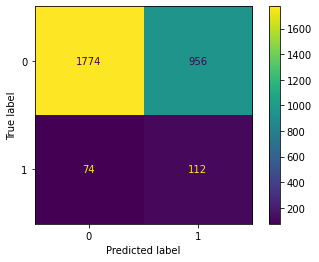

In [ ]:
print("Linear model")
liear_cf = confusion_matrix(y_test, linear_predicts)
ConfusionMatrixDisplay(liear_cf, display_labels=[0,1]).plot(values_format='d')


Ensemble model


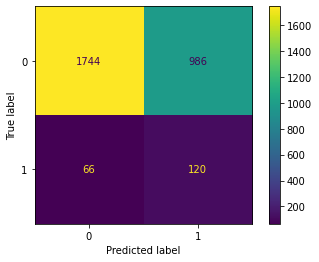

In [ ]:
print("Ensemble model")
ensemble_cf = confusion_matrix(y_test, ensemble_predicts)
ConfusionMatrixDisplay(ensemble_cf, display_labels=[0,1]).plot(values_format='d')



DL model


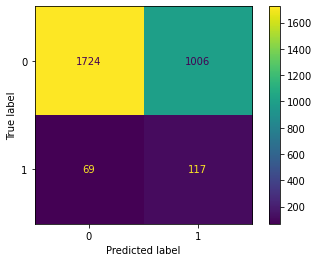

In [ ]:

print("DL model")
DL_cf = confusion_matrix(y_test, DL_predicts)
ConfusionMatrixDisplay(DL_cf, display_labels=[0,1]).plot(values_format='d')

# **Summary and Conclusion**




### **Metric selection**


We chose the metric of ***AUC*** rather then *accuracy* to overcome the fact that the data is heavily imbalanced. At first we considered using *accuracy* as the comparison metric, but evan a model based on a majority rule will achive a high *accuracy* score ( always predicts 0 - no cardiovascular event).

We also considered using the ***Recall*** metric because a high *recall* score will indicate that a high percentage of sick patients will be identified. despite the fact that this metric seems to fit this problem well enougth we chose *AUC* instead.

*AUC* takes into consideration *TPR* and *FPR* while *Percision* (or *sensitivity*) regards only *TPR*. It is our understanding that there is not only a risk in not identifing a sick patient, but there is also a significant risk in identifing a healthy one as sick. A false identification (i.e. *False Positive*) can lead to the wrong treatment and have severe complications. Therefore, we chose the *AUC* score metric.

### **Quantitative results discussion**


As seen by the final results The DL model is proved to perform at the highest level for this task out of the examined models. In addition the ensemble model performed slightly better than the linear model did. As explained above the fact that **the DL model achived the highest *AUC* score means that it's the best model, in our opinion, for this task.**

### **Qualitive results discussion**

We calculated the confusion matrix to better visualize the predictions made by each model.

**The actual desicion of which model to use should be affected by the prefrences of the user.** For example, if the user wants a low false negative rate they should use ensemble model. In contrast if they seek a low false positive rate they should chose the linear model.

# **Methods summary**

### **Linear model: Linear SVC**

**Parameters chosen:**

C: 0.01, loss: 'squared_hinge', max_iter: 50000, tol: 1e-10, no oversampling and full undersampling (same number of samples for each label)


### **Ensemble model: Random Forest Classifier**

**Parameters chosen:**

ccp_alpha: 0.01, criterion: 'entropy', max_depth: 7, max_features: 'log2', min_samples_leaf: 5, min_samples_split: 4, n_estimators: 199, no oversampling and full undersampling (same number of samples for each label)


### **Deep Learning model: Fully Connected Neural Network**

Architecture chosen: One hidden layer with 50 FC units using ReLU activation function. Sigmoid activation for the output layer. binary_crossentropy loss was used as well as Adam optimaizer.

**Parameters chosen:**

epoch: 10, batch: 16, learning rate: 0.001, no oversampling and full undersampling (same number of samples for each label)